Converged at iteration 1
Final log-likelihood: -1041.5602454684695


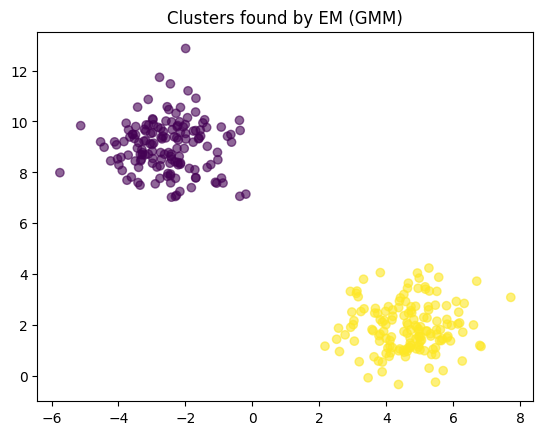

In [1]:
import numpy as np
from scipy.stats import multivariate_normal

class GMM_EM:
    def __init__(self, n_components, max_iter=100, tol=1e-4):
        self.K = n_components      # Number of clusters
        self.max_iter = max_iter
        self.tol = tol             # Convergence tolerance

    def initialize_parameters(self, X):
        N, D = X.shape
        # Initialize means randomly chosen from data points
        indices = np.random.choice(N, self.K, replace=False)
        self.means = X[indices]

        # Initialize covariances to identity matrices
        self.covariances = np.array([np.eye(D)] * self.K)

        # Initialize equal weights
        self.weights = np.ones(self.K) / self.K

    def e_step(self, X):
        N = X.shape[0]
        self.resp = np.zeros((N, self.K))  # Responsibilities

        for k in range(self.K):
            # Calculate weighted pdf of each component
            self.resp[:, k] = self.weights[k] * multivariate_normal.pdf(X, mean=self.means[k], cov=self.covariances[k])

        # Normalize to get probabilities
        total_resp = np.sum(self.resp, axis=1, keepdims=True)
        self.resp /= total_resp

    def m_step(self, X):
        N, D = X.shape
        for k in range(self.K):
            Nk = np.sum(self.resp[:, k])
            self.means[k] = np.sum(self.resp[:, k][:, np.newaxis] * X, axis=0) / Nk

            diff = X - self.means[k]
            self.covariances[k] = np.dot((self.resp[:, k][:, np.newaxis] * diff).T, diff) / Nk

            self.weights[k] = Nk / N

    def log_likelihood(self, X):
        ll = 0
        for k in range(self.K):
            ll += self.weights[k] * multivariate_normal.pdf(X, mean=self.means[k], cov=self.covariances[k])
        return np.sum(np.log(ll))

    def fit(self, X):
        self.initialize_parameters(X)

        log_likelihood_old = None
        for i in range(self.max_iter):
            self.e_step(X)
            self.m_step(X)
            log_likelihood_new = self.log_likelihood(X)

            if log_likelihood_old is not None and abs(log_likelihood_new - log_likelihood_old) < self.tol:
                print(f"Converged at iteration {i}")
                break

            log_likelihood_old = log_likelihood_new

        print(f"Final log-likelihood: {log_likelihood_new}")

    def predict(self, X):
        # After fitting, assign each point to cluster with highest responsibility
        N = X.shape[0]
        resp = np.zeros((N, self.K))
        for k in range(self.K):
            resp[:, k] = self.weights[k] * multivariate_normal.pdf(X, mean=self.means[k], cov=self.covariances[k])
        resp /= np.sum(resp, axis=1, keepdims=True)
        return np.argmax(resp, axis=1)

# Example usage:
if __name__ == "__main__":
    from sklearn.datasets import make_blobs
    import matplotlib.pyplot as plt

    # Generate sample data with 2 clusters
    X, y_true = make_blobs(n_samples=300, centers=2, cluster_std=1.0, random_state=42)

    model = GMM_EM(n_components=2)
    model.fit(X)

    y_pred = model.predict(X)

    plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='viridis', marker='o', alpha=0.6)
    plt.title("Clusters found by EM (GMM)")
    plt.show()
